## Code to Chapter 7 of LangChain for Life Science and Healthcare book, by Dr. Ivan Reznikov

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1DV6ZAV9pIREpBpHO5HWXolMODLfOJD8k?usp=sharing)

## Multi-Agent Protein Analysis System

This notebook demonstrates the implementation of a sophisticated multi-agent system using LangGraph for comprehensive protein analysis. The system orchestrates multiple specialized agents to handle different aspects of protein research, from structure prediction to stability analysis and visualization.

## Key Components

The system consists of several specialized agents:
- **ColabFold Team**: Structure prediction using AlphaFold2
- **ThermoMPNN Team**: Protein stability and mutation analysis
- **Utility Agents**: File operations and sequence retrieval
- **Visualization Agents**: 3D structure rendering and network analysis
- **DNA Analysis**: Sequence generation and gene prediction

<font color='yellow'>Warning: this notebook takes a long time to run end to end</font>

## Environment Setup and Dependencies

First, we install all necessary packages for protein analysis, structure prediction, and visualization:

In [1]:
!python -m pip -q install langchain==0.3.17 langchain_core==0.3.33 langchain_openai==0.3.3 langchain_community langchain_huggingface langgraph==0.2.69 openai==1.61.0 pydantic==2.10.6
!python -m pip -q install Bio py3Dmol nglview transformers==4.53.2 modlamp

In [2]:
!python -m -q pip install torch=='2.4.1+cu121' torchvision=='0.19.1+cu121' torchaudio=='2.4.1+cu121'

/usr/bin/python3: No module named -q


**Package Breakdown:**
- **LangChain suite**: Core framework for building the multi-agent system
- **Bio (BioPython)**: Essential for sequence analysis and PDB file handling
- **py3Dmol/nglview**: 3D molecular visualization
- **transformers/torch**: Deep learning models for protein analysis
- **modlamp**: Peptide analysis and antimicrobial peptide descriptors

In [3]:
from google.colab import userdata
import os

os.environ["OPENAI_API_KEY"] = userdata.get("LC4LS_OPENAI_API_KEY")
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

## Additional Tools Setup

Several specialized tools are configured:

1. **ColabFold**: For AlphaFold2-based structure prediction
2. **ThermoMPNN**: For protein stability analysis
3. **Cold-Spot-Scanner**: For identifying critical interaction regions
4. **Prodigal**: For gene prediction in DNA sequences

### Install ColabFold dependencies

In [4]:
%%bash -s $use_amber $use_msa $use_templates

set -e

USE_AMBER=$1
USE_MSA=$2
USE_TEMPLATES=$3


if [ ! -f COLABFOLD_READY ]; then
  # install dependencies
  python -m pip install -q biopython dm-haiku ml-collections py3Dmol pandas
  # Trick for dev stage because otherwise pip won't install newer git versions
  python -m pip uninstall -y -q colabfold
  python -m pip install -q colabfold[alphafold]==1.5.4
  touch COLABFOLD_READY
fi

# download libraries for interfacing with MMseqs2 API
if [ ${USE_MSA} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f MMSEQ2_READY ]; then
    apt-get -qq -y update 2>&1 1>/dev/null
    apt-get -qq -y install jq curl zlib1g gawk 2>&1 1>/dev/null
    touch MMSEQ2_READY
  fi
fi
# setup conda
if [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f CONDA_READY ]; then
    wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
    rm Miniconda3-latest-Linux-x86_64.sh
    touch CONDA_READY
  fi
fi
# setup template search
if [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then
  conda install -y -q -c conda-forge -c bioconda kalign3=3.2.2 hhsuite=3.3.0 python=3.7 2>&1 1>/dev/null
  touch HH_READY
fi
# setup openmm for amber refinement
if [ ${USE_AMBER} == "True" ] && [ ! -f AMBER_READY ]; then
  conda install -y -q -c conda-forge openmm=7.5.1 python=3.7 pdbfixer 2>&1 1>/dev/null
  wget -qnc https://raw.githubusercontent.com/deepmind/alphafold/main/docker/openmm.patch
  (cd /usr/local/lib/python3.7/site-packages; patch -s -p0 < /content/openmm.patch)
  wget -qnc https://git.scicore.unibas.ch/schwede/openstructure/-/raw/7102c63615b64735c4941278d92b554ec94415f8/modules/mol/alg/src/stereo_chemical_props.txt
  touch AMBER_READY
fi

### Install ColabFold dependencies
To re-run ThermoMPNN on a new protein, you may start on Step 3.

In [5]:
# cleaning out any remaining data
!rm -rf /content/ThermoMPNN
!rm -rf /content/sample_data
!rm /content/*.pdb
!rm /content/*.csv

# import ThermoMPNN github repo
import os

if not os.path.exists("/content/ThermoMPNN"):
    ! git clone https://github.com/Kuhlman-Lab/ThermoMPNN.git
    %cd /content/ThermoMPNN

# downloading various dependencies
# ! pip install omegaconf wandb pytorch-lightning biopython nglview
!python -m pip install -q omegaconf wandb pytorch-lightning biopython py3Dmol

rm: cannot remove '/content/*.pdb': No such file or directory
rm: cannot remove '/content/*.csv': No such file or directory
Cloning into 'ThermoMPNN'...
remote: Enumerating objects: 960, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 960 (delta 85), reused 72 (delta 72), pack-reused 864 (from 1)
Receiving objects: 100% (960/960), 134.09 MiB | 19.87 MiB/s, done.
Resolving deltas: 100% (468/468), done.
Updating files: 100% (60/60), done.
/content/ThermoMPNN


In [6]:
%%bash

cd /content/

if [ ! -f Cold-Spot-Scanner ]; then


    # delete the Cold-scanner/ directory if it already exists
    if [ -d "Cold-Spot-Scanner/" ]; then
        rm -rf Cold-Spot-Scanner/
    fi

    # download model
    git clone https://github.com/sagagugit/Cold-Spot-Scanner --quiet
    touch Cold-Spot-Scanner
fi

cd /content/

In [7]:
%%capture
!python -m pip install --upgrade "jax[cuda12_pip]<0.4.24" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [8]:
!cd /content
!git clone https://github.com/hyattpd/Prodigal
!cd Prodigal && make install
!cd /content/

Cloning into 'Prodigal'...
remote: Enumerating objects: 625, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 625 (delta 6), reused 13 (delta 3), pack-reused 603 (from 1)
Receiving objects: 100% (625/625), 2.03 MiB | 2.03 MiB/s, done.
Resolving deltas: 100% (450/450), done.
gcc -pedantic -Wall -O3 -DSUPPORT_GZIP_COMPRESSED -c -o bitmap.o bitmap.c
gcc -pedantic -Wall -O3 -DSUPPORT_GZIP_COMPRESSED -c -o dprog.o dprog.c
gcc -pedantic -Wall -O3 -DSUPPORT_GZIP_COMPRESSED -c -o gene.o gene.c
gcc -pedantic -Wall -O3 -DSUPPORT_GZIP_COMPRESSED -c -o main.o main.c
In file included from /usr/include/stdio.h:894,
                 from sequence.h:24,
                 from main.c:23:
In function ‘fprintf’,
    inlined from ‘main’ at main.c:265:7:
/usr/include/x86_64-linux-gnu/bits/stdio2.h:105:10: warning: ‘%s’ directive argument is null []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wformat-overflow=-Wformat-ove

In [9]:
!python -m pip freeze | grep "lang\|openai\|Bio\|py3Dmol\|nglview\|transformers\|torch\|modlamp\|flash_attn\|vlm\|evo2\|torch"

google-ai-generativelanguage==0.6.15
google-cloud-language==2.17.2
langchain==0.3.17
langchain-community==0.3.16
langchain-core==0.3.33
langchain-huggingface==0.1.2
langchain-openai==0.3.3
langchain-text-splitters==0.3.5
langcodes==3.5.0
langgraph==0.2.69
langgraph-checkpoint==2.1.1
langgraph-sdk==0.1.74
langsmith==0.3.45
language_data==1.3.0
libclang==18.1.1
modlamp==4.3.2
nglview==3.1.4
openai==1.61.0
py3Dmol==2.5.1
pytorch-lightning==2.5.2
sentence-transformers==4.1.0
torch @ https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl
torchao==0.10.0
torchaudio @ https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl
torchdata==0.11.0
torchmetrics==1.8.0
torchsummary==1.5.1
torchtune==0.6.1
torchvision @ https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp311-cp311-linux_x86_64.whl
transformers==4.53.2


In [10]:
import functools
import hashlib
import json
import operator
import re
import sys
from dataclasses import dataclass
from typing import Dict, List, Annotated, TypedDict, Optional, Any
from urllib import request
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import networkx as nx
import requests
from pathlib import Path
import os

import torch
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoConfig,
    EsmForMaskedLM,
    EsmForProteinFolding,
)

from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, BaseMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool, tool
from langchain_openai import ChatOpenAI
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from pydantic import BaseModel, Field

# Bioinformatics related
from Bio import SeqIO, Entrez, pairwise2
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.PDB import PDBParser
from modlamp.core import BaseSequence
from modlamp.descriptors import PeptideDescriptor
from modlamp.analysis import GlobalAnalysis

# Protein structure and visualization
import py3Dmol
import nglview as nv

# ColabFold related
from colabfold.batch import get_queries, set_model_type, run as colabfold_run
from colabfold.colabfold import plot_plddt_legend, pymol_color_list, alphabet_list
from colabfold.download import download_alphafold_params
from colabfold.colabfold import plot_plddt_legend

# ThermoMPNN related
sys.path.append("/content/ThermoMPNN")
from train_thermompnn import TransferModelPL
from omegaconf import OmegaConf

/usr/local/lib/python3.11/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


### Important Note on Installation
<font color='red'>If you encounter the error "numpy.dtype size changed, may indicate binary incompatibility",
restart the session and re-run all cells. This is a known compatibility issue between
different numpy versions and compiled extensions</font>

In [11]:
if not os.path.isfile("COLABFOLD_READY"):
    !python -m pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'
    !ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold
    !ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold
    !touch COLABFOLD_READY

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
import functools


def print_tool_name(func):
    pass


def print_func_name(func):
    pass

In [71]:
alphabet = "ADEFGHIKLMNPQRSTVWY"


def add_hash(x, y):
    return x + "_" + hashlib.sha1(y.encode()).hexdigest()[:5]


def prepare_data_for_colabfold(query_sequence: str, jobname: str = "test"):
    """Prepares ColabFold. Run before predicting the protein structure given a sequence."""
    %cd /content/

    # remove whitespaces
    query_sequence = "".join(query_sequence.split())

    # remove whitespaces
    jobname = "".join(jobname.split())
    jobname = re.sub(r"\W+", "", jobname)
    jobname = add_hash(jobname, query_sequence)

    with open(f"{jobname}.csv", "w") as text_file:
        text_file.write(f"id,sequence\n{jobname},{query_sequence}")

    queries_path = f"{jobname}.csv"
    return queries_path


def alt_parse_PDB_biounits(x, atoms=["N", "CA", "C"], chain=None):
    """
    input:  x = PDB filename
            atoms = atoms to extract (optional)
    output: (length, atoms, coords=(x,y,z)), sequence
    """

    alpha_1 = list("ARNDCQEGHILKMFPSTWYV-")
    states = len(alpha_1)
    alpha_3 = [
        "ALA",
        "ARG",
        "ASN",
        "ASP",
        "CYS",
        "GLN",
        "GLU",
        "GLY",
        "HIS",
        "ILE",
        "LEU",
        "LYS",
        "MET",
        "PHE",
        "PRO",
        "SER",
        "THR",
        "TRP",
        "TYR",
        "VAL",
        "GAP",
    ]

    aa_1_N = {a: n for n, a in enumerate(alpha_1)}
    aa_3_N = {a: n for n, a in enumerate(alpha_3)}
    aa_N_1 = {n: a for n, a in enumerate(alpha_1)}
    aa_1_3 = {a: b for a, b in zip(alpha_1, alpha_3)}
    aa_3_1 = {b: a for a, b in zip(alpha_1, alpha_3)}

    def AA_to_N(x):
        # ["ARND"] -> [[0,1,2,3]]
        x = np.array(x)
        if x.ndim == 0:
            x = x[None]
        return [[aa_1_N.get(a, states - 1) for a in y] for y in x]

    def N_to_AA(x):
        # [[0,1,2,3]] -> ["ARND"]
        x = np.array(x)
        if x.ndim == 1:
            x = x[None]
        return ["".join([aa_N_1.get(a, "-") for a in y]) for y in x]

    xyz, seq, min_resn, max_resn = {}, {}, 1e6, -1e6
    resn_list = []
    for line in open(x, "rb"):
        line = line.decode("utf-8", "ignore").rstrip()

        # handling MSE and SEC residues
        if line[:6] == "HETATM" and line[17 : 17 + 3] == "MSE":
            line = line.replace("HETATM", "ATOM  ")
            line = line.replace("MSE", "MET")
        elif line[17 : 17 + 3] == "MSE":
            line = line.replace("MSE", "MET")
        elif line[17 : 17 + 3] == "SEC":
            line = line.replace("SEC", "CYS")

        if line[:4] == "ATOM":
            ch = line[21:22]
            if ch == chain or chain is None:
                atom = line[12 : 12 + 4].strip()
                resi = line[17 : 17 + 3]
                resn = line[22 : 22 + 5].strip()

                # RAW resn is defined HERE
                if resn not in resn_list:
                    resn_list.append(resn)  # NEED to keep ins code here
                x, y, z = [float(line[i : (i + 8)]) for i in [30, 38, 46]]
                if resn[-1].isalpha():
                    resa, resn = resn[-1], int(resn[:-1]) - 1
                else:
                    resa, resn = "", int(resn) - 1
                if resn < min_resn:
                    min_resn = resn
                if resn > max_resn:
                    max_resn = resn
                if resn not in xyz:
                    xyz[resn] = {}
                if resa not in xyz[resn]:
                    xyz[resn][resa] = {}
                if resn not in seq:
                    seq[resn] = {}
                if resa not in seq[resn]:
                    seq[resn][resa] = resi

                if atom not in xyz[resn][resa]:
                    xyz[resn][resa][atom] = np.array([x, y, z])
                # print(resn_list)

    # convert to numpy arrays, fill in missing values
    seq_, xyz_ = [], []
    # print(seq)
    try:
        for resn in range(min_resn, max_resn + 1):
            if resn in seq:
                for k in sorted(seq[resn]):
                    seq_.append(aa_3_N.get(seq[resn][k], 20))
            else:
                seq_.append(20)

            if resn in xyz:
                for k in sorted(xyz[resn]):
                    for atom in atoms:
                        if atom in xyz[resn][k]:
                            xyz_.append(xyz[resn][k][atom])
                        else:
                            xyz_.append(np.full(3, np.nan))
            else:
                for atom in atoms:
                    xyz_.append(np.full(3, np.nan))
        return (
            np.array(xyz_).reshape(-1, len(atoms), 3),
            N_to_AA(np.array(seq_)),
            list(dict.fromkeys(resn_list)),
        )
    except TypeError:
        return "no_chain", "no_chain", "no_chain"


def alt_parse_PDB(
    path_to_pdb, input_chain_list=None, ca_only=False, side_chains=False, mut_chain=None
):
    c = 0
    pdb_dict_list = []
    init_alphabet = [
        "A",
        "B",
        "C",
        "D",
        "E",
        "F",
        "G",
        "H",
        "I",
        "J",
        "K",
        "L",
        "M",
        "N",
        "O",
        "P",
        "Q",
        "R",
        "S",
        "T",
        "U",
        "V",
        "W",
        "X",
        "Y",
        "Z",
        "a",
        "b",
        "c",
        "d",
        "e",
        "f",
        "g",
        "h",
        "i",
        "j",
        "k",
        "l",
        "m",
        "n",
        "o",
        "p",
        "q",
        "r",
        "s",
        "t",
        "u",
        "v",
        "w",
        "x",
        "y",
        "z",
    ]
    extra_alphabet = [str(item) for item in list(np.arange(300))]
    chain_alphabet = init_alphabet + extra_alphabet

    if input_chain_list:
        chain_alphabet = input_chain_list

    biounit_names = [path_to_pdb]
    for biounit in biounit_names:
        my_dict = {}
        s = 0
        concat_seq = ""
        concat_N = []
        concat_CA = []
        concat_C = []
        concat_O = []
        concat_mask = []
        coords_dict = {}
        for letter in chain_alphabet:
            if ca_only:
                sidechain_atoms = ["CA"]
            elif side_chains:
                sidechain_atoms = [
                    "N",
                    "CA",
                    "C",
                    "O",
                    "CB",
                    "CG",
                    "CG1",
                    "OG1",
                    "OG2",
                    "CG2",
                    "OG",
                    "SG",
                    "CD",
                    "SD",
                    "CD1",
                    "ND1",
                    "CD2",
                    "OD1",
                    "OD2",
                    "ND2",
                    "CE",
                    "CE1",
                    "NE1",
                    "OE1",
                    "NE2",
                    "OE2",
                    "NE",
                    "CE2",
                    "CE3",
                    "NZ",
                    "CZ",
                    "CZ2",
                    "CZ3",
                    "CH2",
                    "OH",
                    "NH1",
                    "NH2",
                ]
            else:
                sidechain_atoms = ["N", "CA", "C", "O"]
            xyz, seq, resn_list = alt_parse_PDB_biounits(
                biounit, atoms=sidechain_atoms, chain=letter
            )
            if resn_list != "no_chain":
                # if mut_chain is not None:
                # if letter == mut_chain:
                #   my_dict[f'resn_list_{letter}'] = list(resn_list)
                # else:
                my_dict[f"resn_list_{letter}"] = list(resn_list)
            if type(xyz) != str:
                concat_seq += seq[0]
                my_dict["seq_chain_" + letter] = seq[0]
                coords_dict_chain = {}
                if ca_only:
                    coords_dict_chain["CA_chain_" + letter] = xyz.tolist()
                elif side_chains:
                    coords_dict_chain["SG_chain_" + letter] = xyz[:, 11].tolist()
                else:
                    coords_dict_chain["N_chain_" + letter] = xyz[:, 0, :].tolist()
                    coords_dict_chain["CA_chain_" + letter] = xyz[:, 1, :].tolist()
                    coords_dict_chain["C_chain_" + letter] = xyz[:, 2, :].tolist()
                    coords_dict_chain["O_chain_" + letter] = xyz[:, 3, :].tolist()
                my_dict["coords_chain_" + letter] = coords_dict_chain
                s += 1

        fi = biounit.rfind("/")
        my_dict["name"] = biounit[(fi + 1) : -4]
        my_dict["num_of_chains"] = s
        my_dict["seq"] = concat_seq
        # my_dict['resn_list'] = list(resn_list)
        if s <= len(chain_alphabet):
            pdb_dict_list.append(my_dict)
            c += 1
    return pdb_dict_list


def ssm_mutation(pdb, chain):
    # make mutation list for SSM run
    resn_lists = [k for k in pdb.keys() if k.startswith("resn_list_")]
    mutation_list = []

    offset = 0
    for rlist in resn_lists:
        # add gaps where needed
        for n, res in enumerate(pdb[rlist]):
            seq_pos = pdb[rlist].index(res)
            wtAA = pdb["seq"][seq_pos + offset]
            if wtAA == "-":
                pdb[rlist].insert(pdb[rlist].index(res), "-")

        if rlist.endswith(chain):
            for n, res in enumerate(pdb[rlist]):
                seq_pos = pdb[rlist].index(res)
                wtAA = pdb["seq"][seq_pos + offset]
                if wtAA != "-":
                    for mutAA in alphabet:
                        r = str(seq_pos + offset)
                        mutation_list.append(wtAA + r + mutAA)
            return mutation_list
        # offset absolute position
        offset += len(pdb[rlist])

    return mutation_list


def run_coldspot_scanner(pdb_file: str, chain_a: str, chain_b: str) -> str:
    """Run Cold-Spot-Scanner analysis on a protein complex"""
    # Prepare input
    pdb_id = os.path.basename(pdb_file).split(".")[0]
    input_str = f"{pdb_id}_{chain_a}:{chain_b}"

    %cd /content/Cold-Spot-Scanner/
    %rm -rf results
    %rm -f Cold_spots_residues_due_to_CH_interactions.csv
    %rm -f Cold_spots_due_to_SC_interactions.csv

    with open("PDB_and_chain", "w") as f:
        f.write(input_str)

    try:
        !python init_database.py x
    except Exception as e:
        print(f"DB already exists: {e}")
    !python setupPpiDb.py PDB_and_chain x
    !cp /content/Cold-Spot-Scanner/results/cold_spots/Cold_spots_residues_due_to_CH_interactions.csv /content/Cold-Spot-Scanner
    !cp /content/Cold-Spot-Scanner/results/cold_spots/Cold_spots_due_to_SC_interactions.csv /content/Cold-Spot-Scanner

    return "Cold-Spot-Scanner analysis complete"


def download_pdb(
    pdbcode, datadir="/content", downloadurl="https://files.rcsb.org/download/"
):
    """
    Downloads a PDB file from the Internet and saves it in a data directory.
    :param pdbcode: The standard PDB ID e.g. '3ICB' or '3icb'
    :param datadir: The directory where the downloaded file will be saved
    :param downloadurl: The base PDB download URL, cf.
        `https://www.rcsb.org/pages/download/http#structures` for details
    :return: the full path to the downloaded PDB file or None if something went wrong
    """

    pdbfn = pdbcode + ".pdb"
    url = downloadurl + pdbfn
    outfnm = os.path.join(datadir, pdbfn)
    try:
        request.urlretrieve(url, outfnm)
        return outfnm
    except Exception as err:
        print(str(err), file=sys.stderr)
        return None


def get_chains(pdb):
    # collect list of chains in PDB to match with input
    pdb_filepath = f"/content/{pdb}.pdb"
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("", pdb_filepath)
    chains = [c.id for c in structure.get_chains()]
    return chains


def load_fasta_from_path(file_path):
    """a little helper to load records from a .fasta file"""
    sequences = []
    with open(file_path, "r") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            sequences.append(record)
    return sequences


@dataclass
class Mutation:
    position: int
    wildtype: str
    mutation: str
    pdb: str

## Core Data Structures and State Management

### ProteinState Class

**State Components:**
- **messages**: Conversation history between agents
- **sequence**: Current protein sequence being analyzed
- **predictions**: Results from structure/stability predictions
- **properties**: Calculated biochemical properties
- **visualization**: 3D rendering objects

The system uses a sophisticated state management approach:

In [15]:
class ProteinState(Dict[str, Any]):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str
    sequence: str = ""
    predictions: Dict[str, Any] = {}
    properties: Dict[str, Any] = {}
    visualization: Any = None


@tool
def save_pdb(pdb_content: str, filename: str) -> str:
    """Save PDB file to disk"""
    with open(filename, "w") as f:
        f.write(pdb_content)
    return f"PDB saved to {filename}"


@tool
def load_pdb(filename: str) -> str:
    """Load PDB file from disk"""
    with open(filename, "r") as f:
        return f.read()

## Structure Prediction Tools

### ESMFold Integration

**Key Features:**
- Single-sequence structure prediction (no MSA required)
- Fast inference suitable for real-time applications
- Good accuracy for shorter sequences
- Outputs standard PDB format files

ESMFold provides rapid protein structure prediction using Meta's ESM language model:

In [16]:
@tool
def run_esmfold_prediction(protein_seq: str) -> str:
    """Predict protein structure using ESMFold"""
    esmfold = EsmForProteinFolding.from_pretrained(
        "facebook/esmfold_v1", low_cpu_mem_usage=True
    )
    esmfold = esmfold.to(device)
    esmfold.esm = esmfold.esm.half()
    esmfold_tokenizer = AutoTokenizer.from_pretrained("facebook/esmfold_v1")

    esmfold_input = esmfold_tokenizer(
        [protein_seq], return_tensors="pt", add_special_tokens=False
    )

    # Generate structure prediction
    with torch.inference_mode():
        esmfold_output = esmfold(**esmfold_input.to(device))
        pdb_content = esmfold.output_to_pdb(esmfold_output)[0]

    protein_structure_pdb = f"esmfold_{protein_seq}.pdb"
    with open(protein_structure_pdb, "w") as f:
        f.write(pdb_content)

    return pdb_content

### ColabFold Integration

**Advanced Parameters:**
- **msa_mode**: Controls multiple sequence alignment generation
- **num_models**: Number of neural network models to ensemble
- **num_recycles**: Iterative refinement cycles
- **pair_mode**: Handles protein complexes vs. single chains

**Quality Assessment:**
- **pLDDT scores**: Per-residue confidence estimates
- **PAE (Predicted Aligned Error)**: Inter-residue distance accuracy
- **Ranking**: Automatic selection of best models

ColabFold implements AlphaFold2 with optimizations for Colab environments:

In [17]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

protgpt2_model = GPT2LMHeadModel.from_pretrained(
    "nferruz/ProtGPT2",
    trust_remote_code=True,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
)
protgpt2_tokenizer = GPT2Tokenizer.from_pretrained("nferruz/ProtGPT2")

protgpt2 = pipeline(
    "text-generation", model=protgpt2_model, tokenizer=protgpt2_tokenizer
)

Device set to use cuda:0


In [18]:
@tool
def run_colabfold_prediction(
    query_sequence: str,
    msa_mode: str,
    num_models: int = 5,
    num_recycles: int = 3,
    jobname: str = "test",
    pair_mode: str = "unpaired+paired",
) -> str:
    """Predict protein structure using ColabFold"""
    # Setup params
    queries_path = prepare_data_for_colabfold(query_sequence, jobname=jobname)
    queries, is_complex = get_queries(queries_path)
    model_type = set_model_type(is_complex, "auto")

    # Download params and run
    download_alphafold_params(model_type, Path("."))
    results = colabfold_run(
        queries=queries,
        result_dir=".",
        msa_mode=msa_mode,
        num_models=num_models,
        num_recycles=num_recycles,
        is_complex=is_complex,
        use_amber=False,
        use_templates=False,
        rank_mode="auto",
        pair_mode=pair_mode,
        stop_at_score=float(100),
    )

    return f"Prediction complete. Results in {jobname} directory"


@tool
def visualize_structure(pdb_file: str, color: str = "lDDT") -> str:
    """Visualize ColabFold protein structure using py3Dmol"""
    view = py3Dmol.view()
    view.addModel(open(pdb_file, "r").read(), "pdb")

    if color == "lDDT":
        view.setStyle(
            {
                "cartoon": {
                    "colorscheme": {
                        "prop": "b",
                        "gradient": "roygb",
                        "min": 50,
                        "max": 90,
                    }
                }
            }
        )
    elif color == "rainbow":
        view.setStyle({"cartoon": {"color": "spectrum"}})

    view.zoomTo()
    return view.show()


@tool
def create_quality_plots(jobname: str, metrics: Dict) -> Dict[str, str]:
    """Create quality assessment plots"""
    from colabfold.plot import plot_msa_v2, plot_plddt_legend

    # Create pLDDT plot
    plt.figure()
    plt.plot(metrics["plddt"])
    plt.title("Predicted lDDT")
    plt.savefig(f"{jobname}_plddt.png")

    # Create PAE plot if available
    if metrics["pae"] is not None:
        plt.figure()
        plt.imshow(metrics["pae"])
        plt.title("Predicted Alignment Error")
        plt.savefig(f"{jobname}_pae.png")

    return {
        "plddt_plot": f"{jobname}_plddt.png",
        "pae_plot": f"{jobname}_pae.png" if metrics["pae"] else None,
    }


@tool
def plot_results(jobname: str) -> str:
    """Plot ColabFold results including pLDDT and PAE"""
    plt.figure(figsize=(10, 5))

    # Plot pLDDT
    plddt_file = f"{jobname}/{jobname}_plddt.png"
    if os.path.exists(plddt_file):
        img = plt.imread(plddt_file)
        plt.subplot(121)
        plt.imshow(img)
        plt.title("pLDDT")

    # Plot PAE
    pae_file = f"{jobname}/{jobname}_pae.png"
    if os.path.exists(pae_file):
        img = plt.imread(pae_file)
        plt.subplot(122)
        plt.imshow(img)
        plt.title("PAE")

    plt.tight_layout()
    return plt.show()


@tool
def generate_protein(input_text: str) -> str:
    """Generates a protein sequence with the desired properties using ProtGPT2."""
    sequences = protgpt2(
        "<|endoftext|>",
        max_length=100,
        do_sample=True,
        top_k=950,
        repetition_penalty=1.2,
        num_return_sequences=1,
        eos_token_id=0,
    )
    print(f"Generated proteins: {sequences}")
    return sequences[0]["generated_text"]

    """
    tokenizer = AutoTokenizer.from_pretrained("nferruz/ProtGPT2")
    model = AutoModelForCausalLM.from_pretrained("nferruz/ProtGPT2")
    inputs = tokenizer(input_text, return_tensors="pt").to(device)
    outputs = model.generate(inputs.input_ids, max_length=100, temperature=0.7, top_k=500, repetition_penalty=1.2, eos_token_id=0)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)
    """


@tool
def validate_sequences(self, sequences: List[str]) -> Dict:
    """Validate generated protein sequences"""
    results = []
    valid_aas = set("ACDEFGHIKLMNPQRSTVWY")

    for protein in sequences:
        is_valid = all(aa in valid_aas for aa in protein.sequence)
        validation = {
            "sequence": protein.sequence,
            "is_valid": is_valid,
            "length": len(protein.sequence),
            "invalid_residues": [aa for aa in protein.sequence if aa not in valid_aas],
        }
        results.append(validation)

        return results


@tool
def visualize_network(interactions: Dict[str, List[str]]) -> plt.Figure:
    """Generates a network visualization for protein interactions."""
    print("Tool: visualize_network")
    if not interactions:
        raise ValueError("Interactions dictionary cannot be empty.")

    G = nx.from_dict_of_lists(interactions)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    nx.draw(
        G, pos, with_labels=True, node_color="lightblue", node_size=1500, font_size=10
    )
    return plt.gcf()


@tool
def calculate_properties(sequence: str) -> Dict[str, Any]:
    """Calculates properties such as charge, amino acid composition and hydrophobicity of the protein sequence."""
    analysis = ProteinAnalysis(sequence)
    return {
        "charge": analysis.charge_at_pH(7.0),
        "hydrophobicity": analysis.gravy(),
        "amino_acid_composition": analysis.get_amino_acids_percent(),
    }


@tool
def get_sequence(protein_name: str) -> str:
    """Fetches protein sequence from NCBI given a protein name."""
    Entrez.email = "your_email@example.com"
    handle = Entrez.esearch(db="protein", term=protein_name)
    record = Entrez.read(handle)
    if record["Count"] == "0":
        return None
    handle = Entrez.efetch(
        db="protein", id=record["IdList"][0], rettype="fasta", retmode="text"
    )
    sequence = SeqIO.read(handle, "fasta")
    return str(sequence.seq)


@tool
def generate_mutation_heatmap(
    protein_sequence: str, start_pos: int = 1, end_pos: int = None
):
    """Generates a mutation heatmap for the given protein sequence."""
    model_name = "facebook/esm2_t6_8M_UR50D"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = EsmForMaskedLM.from_pretrained(model_name)

    input_ids = tokenizer.encode(protein_sequence, return_tensors="pt")
    sequence_length = input_ids.shape[1] - 2
    if end_pos is None:
        end_pos = sequence_length
    amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
    heatmap = np.zeros((20, end_pos - start_pos + 1))

    for position in range(start_pos, end_pos + 1):
        masked_input_ids = input_ids.clone()
        masked_input_ids[0, position] = tokenizer.mask_token_id
        with torch.no_grad():
            logits = model(masked_input_ids).logits
        probabilities = torch.nn.functional.softmax(logits[0, position], dim=0)
        log_probabilities = torch.log(probabilities)
        wt_residue = input_ids[0, position].item()
        log_prob_wt = log_probabilities[wt_residue].item()
        for i, amino_acid in enumerate(amino_acids):
            log_prob_mt = log_probabilities[
                tokenizer.convert_tokens_to_ids(amino_acid)
            ].item()
            heatmap[i, position - start_pos] = log_prob_mt - log_prob_wt

    plt.figure(figsize=(15, 5))
    plt.imshow(heatmap, cmap="viridis", aspect="auto")
    plt.xticks(
        range(end_pos - start_pos + 1), list(protein_sequence[start_pos - 1 : end_pos])
    )
    plt.yticks(range(20), amino_acids)
    plt.xlabel("Position in Protein Sequence")
    plt.ylabel("Amino Acid Mutations")
    plt.title("Predicted Effects of Mutations on Protein Sequence (LLR)")
    plt.colorbar(label="Log Likelihood Ratio (LLR)")
    return plt.show()

## Protein Stability Analysis

### ThermoMPNN System

**Analysis Process:**
1. **PDB Parsing**: Extract atomic coordinates and sequence information
2. **Mutation Generation**: Create all possible single amino acid substitutions
3. **Stability Prediction**: Calculate ΔΔG values for each mutation
4. **Result Processing**: Generate comprehensive stability profiles

**Output Interpretation:**
- **Negative ΔΔG**: Stabilizing mutations
- **Positive ΔΔG**: Destabilizing mutations
- **Magnitude**: Degree of stability change (kcal/mol)

ThermoMPNN performs comprehensive stability analysis through systematic mutagenesis:

In [19]:
@tool
def run_thermompnn_prediction(pdb_file: str, chain: str = "A") -> str:
    """Run ThermoMPNN stability prediction on a protein structure"""
    # Parse PDB and setup params
    if not os.path.exists(pdb_file):
        # pdb_content = download_pdb(pdb_file)
        # save_pdb(pdb_content, pdb_file)
        download_pdb(pdb_file, "/content/")

    pdb_filepath = f"/content/{pdb_file}.pdb"
    pdb_dict = alt_parse_PDB(path_to_pdb=pdb_filepath, input_chain_list=[chain])

    # Generate mutation list
    mutation_list = ssm_mutation(pdb_dict[0], chain)
    final_mutation_list = []
    resn_key = [
        k for k in pdb_dict[0] if k.startswith("resn_list_") and k.endswith(chain)
    ]
    assert len(resn_key) == 1
    resn_key = resn_key[0]

    # Validate mutations
    for m in mutation_list:
        m = m.strip()
        wtAA, position, mutAA = str(m[0]), str(m[1:-1]), str(m[-1])
        pdb_wtAA = pdb_dict[0]["seq"][int(position)]
        assert (
            pdb_wtAA == wtAA
        ), f"Position {position}{wtAA} does not match position {position}{pdb_wtAA} in PDB file"

        mutation_obj = Mutation(
            int(position), pdb_wtAA, mutAA, os.path.basename(pdb_filepath)
        )
        final_mutation_list.append(mutation_obj)

    # Load model and run prediction
    cfg = {
        "training": {
            "num_workers": 8,
            "learn_rate": 0.001,
            "epochs": 100,
            "lr_schedule": True,
        },
        "model": {
            "hidden_dims": [64, 32],
            "subtract_mut": True,
            "num_final_layers": 2,
            "freeze_weights": True,
            "load_pretrained": True,
            "lightattn": True,
            "lr_schedule": True,
        },
        "platform": {"accel": "gpu", "thermompnn_dir": "/content/ThermoMPNN/"},
    }
    conf = OmegaConf.create(cfg)
    model = TransferModelPL.load_from_checkpoint(
        "/content/ThermoMPNN/models/thermoMPNN_default.pt", cfg=conf
    ).model

    # Run prediction
    model.eval()
    with torch.no_grad():
        predictions, _ = model(pdb_dict, final_mutation_list)

    ddG_list = []
    for p in predictions:
        ddG_list.append(p["ddG"].item())

    data = {"Mutation": mutation_list, "ddG (kcal/mol)": ddG_list}
    with open(
        f"/content/{pdb_file}_thermompnn_predictions.json", "w", encoding="utf-8"
    ) as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

    return data

### Visualization Capabilities

#### 2D Heatmaps

**Features:**
- Position vs. amino acid mutation matrix
- Color-coded stability effects
- Wildtype annotation
- Disulfide bond penalty system

In [20]:
@tool
def visualize_thermompnn_heatmap(
    pdb_file: str,
    chain: str = "A",
    include: bool = False,
    enable: bool = True,
    penalize: bool = True,
):
    """Visualize ThermoMPNN results as output heatmap.
    include: include cys mutations or not
    penalize: penalize disulfide breakage (recommended)
    enable: enable multi-chain inference
    """
    pdb_file = pdb_file.replace(".pdb", "")
    with open(f"/content/{pdb_file}_thermompnn_predictions.json") as data_file:
        data = json.load(data_file)

    pdb_filepath = f"/content/{pdb_file}.pdb"

    df = pd.DataFrame(data)
    df["ddG (kcal/mol)"] = df["ddG (kcal/mol)"].round(4)
    df["pos"] = df["Mutation"].str[1:-1]
    df["wtAA"] = df["Mutation"].str[0]
    df["mutAA"] = df["Mutation"].str[-1]

    if len(chain) < 1:
        chain_list = [get_chains(pdb_file)[0]]
        Chain = chain_list[0]
        print(
            f"Using ThermoMPNN model to predict stability across chains: {chain_list}"
        )
    else:
        Chain = chain
        chain_list = [Chain]
        pdb_chains = get_chains(pdb_file)

    if penalize:
        # re-load PDB with side chains enabled
        if (
            enable
        ):  # multi-chain inference requires retrieving all chains for predictions
            pdb_dict = alt_parse_PDB(
                path_to_pdb=pdb_filepath,
                input_chain_list=get_chains(pdb_file),
                mut_chain=Chain,
                side_chains=True,
            )
        else:
            pdb_dict = alt_parse_PDB(
                path_to_pdb=pdb_filepath, input_chain_list=chain_list, side_chains=True
            )

        # collect all SG coordinates from all chains
        coords_all = [k for k in pdb_dict[0].keys() if k.startswith("coords")]
        chains = [c[-1] for c in coords_all]
        sg_coords = [
            pdb_dict[0][c][f"SG_chain_{chain}"] for c, chain in zip(coords_all, chains)
        ]
        sg_coords = np.concatenate(sg_coords, axis=0)

        # calculate pairwise distance and threshold to find disulfides
        from scipy.spatial.distance import cdist

        dist = cdist(sg_coords, sg_coords)
        dist = np.nan_to_num(dist, 10000)
        hits = np.where((dist < 3) & (dist > 0))  # tuple of two [N] arrays of indices

        # match hit indices to actual resns for penalty
        resn_key = [
            k
            for k in pdb_dict[0].keys()
            if k.startswith("resn_list_") and k.endswith(Chain)
        ][0]
        all_resns = pdb_dict[0][resn_key]
        bad_resns, skip_resns = [], []

        hits = np.unique(np.concatenate(hits))
        scored_pos = df.pos.unique()
        for h in hits:
            if str(h) in scored_pos:
                bad_resns.append(str(h))
            else:
                skip_resns.append(str(h))

        print("Identified the following disulfide engaged residues:", bad_resns)
        if len(skip_resns) > 0:
            print(
                "Skipped penalty for the following residues due to no matching residue found in mutated chain:",
                skip_resns,
            )

        # apply penalty
        penalty = 2  # in kcal/mol - higher is less stable
        mask = (
            df["pos"].isin(bad_resns)
            & (df["wtAA"] != df["mutAA"])
            & (df["wtAA"] == "C")
        )
        df.loc[mask, "ddG (kcal/mol)"] = df.loc[mask, "ddG (kcal/mol)"] + penalty

    def raw_to_pdb_num(df, pdb, resn_key):
        """Quick conversion from raw (global) numbering to PDB numbers"""
        resns = pdb[resn_key]
        unique_pos = df["pos"].unique()
        assert len(unique_pos) == len(
            resns
        ), "Cannot convert raw to PDB numbering. Keeping raw numbering."

        new_pos = {raw: proc for raw, proc in zip(unique_pos, resns)}
        df["pos"] = df["pos"].map(new_pos)
        df["Mutation"] = df["wtAA"] + df["pos"].astype(str) + df["mutAA"]
        return df

    df = raw_to_pdb_num(df, pdb_dict[0], resn_key)

    pos = df["pos"].unique()
    wt_data = []
    for p in pos:
        wt = df.loc[df["pos"] == p].wtAA.unique()[0]
        wt_data.append(wt)

    positions = df["pos"].unique()
    arr = np.zeros((positions.size, len(alphabet)), dtype=float)

    if include:
        new_alphabet = "QENHDRKTSAGMCLVIWYFP"
    else:
        new_alphabet = "QENHDRKTSAGMLVIWYFP"

    for p_idx, p in enumerate(positions):
        for a_idx, a in enumerate(new_alphabet):
            arr[p_idx, a_idx] = df.loc[(df["pos"] == p) & (df["mutAA"] == a)][
                "ddG (kcal/mol)"
            ].iloc[0]

    sns.set()
    sns.set(rc={"figure.figsize": (positions.size // 4, 5)})
    g = sns.heatmap(
        data=arr.T,
        cmap="RdBu_r",
        center=0,
        robust=True,
        xticklabels=positions,
        yticklabels=new_alphabet,
        vmin=-3,
        vmax=3,
        linewidth=0.5,
        cbar_kws={"label": "ddG (kcal/mol)"},
    )

    # annotate wildtypes - experimental
    if include:
        for n, wtAA in enumerate(wt_data):
            x = n
            y = new_alphabet.index(wtAA)
            plt.text(
                x + 0.5,
                y + 0.5,
                "x",
                horizontalalignment="center",
                verticalalignment="center",
            )

    g.set(xlabel="Position", ylabel="Amino Acid", title="SSM Thermostability Profile")
    plt.yticks(rotation=0, ha="right")

    fname_heatmap = f"/content/{pdb_file}.pdf"
    plt.savefig(fname_heatmap)
    return plt.show()

#### 3D Structure Mapping

**Visualization Methods:**
- **ALA**: Alanine scanning mutagenesis effects
- **BEST**: Most stabilizing mutation at each position
- **ABS**: Absolute average mutation effects
- **RAW**: Raw average effects

In [21]:
@tool
def visualize_thermompnn_3d(
    pdb_file: str, chain: str = "A", method: str = "ALA"
) -> str:
    """Visualize ThermoMPNN results as a structure sensitivity map from ddG_list prediction list"""
    pdb_file = pdb_file.replace(".pdb", "")
    with open(f"/content/{pdb_file}_thermompnn_predictions.json".lower()) as data_file:
        data = json.load(data_file)

    pdb_filepath = f"/content/{pdb_file}.pdb"

    df = pd.DataFrame(data)
    df["pos"] = df["Mutation"].str[1:-1]
    df["wtAA"] = df["Mutation"].str[0]
    df["mutAA"] = df["Mutation"].str[-1]

    sensitivity = []
    for p in df["pos"].unique():
        pos_slice = df.loc[df["pos"] == p]
        if method == "BEST":
            pos_sens = pos_slice["ddG (kcal/mol)"].min()
        elif method == "RAW":
            pos_sens = pos_slice["ddG (kcal/mol)"].mean()
        elif method == "ABS":
            pos_sens = pos_slice["ddG (kcal/mol)"].abs().mean()
        else:  # method == "ALA"
            pos_slice = pos_slice.loc[pos_slice["mutAA"] == "A"]
            pos_sens = pos_slice["ddG (kcal/mol)"].mean()
        sensitivity.append(pos_sens)

    # Map to structure
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("", pdb_filepath)
    chain_obj = [c for c in structure.get_chains() if c.id == chain][0]
    pos_list = df["pos"].unique().astype(str)
    residues = [r for r in chain_obj.get_residues() if str(r.id[1]) in pos_list]

    for s, r in zip(sensitivity, residues):
        for atom in r:
            atom.set_bfactor(s)

    # Create visualization
    view = py3Dmol.view()
    view.addModel(open(pdb_filepath, "r").read(), "pdb")
    if method == "ABS":
        max_sens, min_sens = 3, 0
        gradient = "linear"
        colors = ["white", "red"]
        params = {
            "cartoon": {
                "colorscheme": {
                    "prop": "b",
                    "gradient": gradient,
                    "min": min_sens,
                    "max": max_sens,
                    "colors": colors,
                }
            }
        }
    else:
        max_sens, min_sens = -3, 3
        gradient = "rwb"
        params = {
            "cartoon": {
                "colorscheme": {
                    "prop": "b",
                    "gradient": gradient,
                    "min": min_sens,
                    "max": max_sens,
                }
            }
        }

    view.setStyle(params)
    view.zoomTo()
    return view.show()

## Cold Spot Analysis

### Protein-Protein Interaction Critical Regions

**Analysis Types:**
1. **CH Interactions**: Backbone-mediated contacts
2. **SC Interactions**: Side chain-mediated contacts

**Applications:**
- Drug target identification
- Interface engineering
- Binding affinity optimization

Cold spots represent amino acids crucial for protein-protein interactions:


In [79]:
@tool
def visualize_coldspots(pdb_file: str, chain_a: str = "A", chain_b: str = "B") -> str:
    """Visualize cold spots in the protein structure"""
    if not os.path.exists(pdb_file):
        # pdb_content = download_pdb(pdb_file)
        # save_pdb(pdb_content, pdb_file)
        pdb_content = download_pdb(pdb_file, "/content/Cold-Spot-Scanner")

    # pdb_filepath =  f"/content/{pdb_file}.pdb"

    %cd /content/Cold-Spot-Scanner
    run_coldspot_scanner(pdb_file, chain_a, chain_b)
    # Load results
    df_ch = pd.read_csv("Cold_spots_residues_due_to_CH_interactions.csv", skiprows=1)
    df_sc = pd.read_csv("Cold_spots_due_to_SC_interactions.csv", skiprows=1)

    df_ch = df_ch.dropna()
    df_sc = df_sc.dropna()
    df_ch["Chain"] = df_ch["Chain"].str.lstrip()
    df_sc["Chain"] = df_sc["Chain"].str.lstrip()

    # Create visualization
    view = py3Dmol.view(width=800, height=600)
    pdb_id = os.path.basename(pdb_file).split(".")[0]

    try:
        with open(f"{pdb_id}Sepereated_clusters.pdb") as ifile:
            system = "".join([x for x in ifile])
        view.addModelsAsFrames(system)
    except:
        pass

    with open(f"{pdb_id}_C.pdb") as ifilex:
        systemx = "".join([x for x in ifilex])

    %cd /content

    view.addModelsAsFrames(systemx)
    view.setStyle({"model": -1}, {"cartoon": {"colorscheme": "chain"}})

    # Highlight cold spots
    for idx, row in df_sc.iterrows():
        chain = row["Chain"]
        resi = row["Residue_number"]
        view.setStyle({"chain": chain, "resi": str(resi)}, {"stick": {"color": "blue"}})

    for idx, row in df_ch.iterrows():
        chain = row["Chain"]
        resi = row["Residue_number"]
        view.setStyle(
            {"chain": chain, "resi": str(resi)}, {"stick": {"color": "yellow"}}
        )

    view.zoomTo()
    return view.show()

## Multi-Agent Architecture

### Team Structure

The system employs a hierarchical multi-agent architecture:

#### ColabFold Team
- **Calculation Agent**: Runs structure predictions
- **Visualization Agent**: Creates 3D renderings and quality plots
- **Supervisor**: Coordinates team activities

#### ThermoMPNN Team
- **Calculation Agent**: Performs stability analysis
- **Visualization Agent**: Creates heatmaps and 3D stability maps
- **Supervisor**: Manages analysis workflow

#### Master Supervisor
Orchestrates all specialized teams and handles:
- Task routing and delegation
- Resource allocation
- Result integration
- User interaction

In [63]:
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )


def create_agent(llm: ChatOpenAI, tools: List[BaseTool], system_prompt: str):
    """Create an agent with specific tools and prompt"""
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )

    agent = create_openai_functions_agent(llm, tools, prompt)
    return AgentExecutor(agent=agent, tools=tools)

### Communication Protocol

Agents communicate through structured message passing:

In [64]:
# Node functions
def agent_node(state: Dict, agent: AgentExecutor, name: str) -> Dict:
    """Generic node function for agents"""
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}


def get_last_message(state) -> str:
    return state["messages"][-1].content


def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

**Message Flow:**
1. User query → Master Supervisor
2. Task analysis and agent selection
3. Specialized agent execution
4. Result aggregation and response

In [49]:
# Initialize LLM and create agents
llm = ChatOpenAI(model="gpt-4o-mini")

### Creating ColabFold Agents

The system creates specialized agents for ColabFold protein structure prediction:


In [26]:
colabfold_calc_agent = create_agent(
    llm,
    [run_colabfold_prediction],
    "You are a calculation agent that runs ColabFold predictions",
)

colabfold_viz_agent = create_agent(
    llm,
    [visualize_structure, plot_results],
    "You are a visualization agent that creates structure visualizations",
)

### Team Supervisor

A supervisor coordinates between calculation and visualization agents:

In [27]:
# Create team supervisors
colabfold_supervisor = create_team_supervisor(
    llm,
    "You are supervising the ColabFold team with calculation and visualization agents"
    "When finished, respond with FINISH.",
    ["Calculate", "Visualize"],
)

/tmp/ipython-input-23-2469773786.py:34: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 1.0.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


### Graph Construction

#### Node Creation

Specialized node functions are created using functools.partial:

In [28]:
# Create specific node functions
colabfold_calc_node = functools.partial(
    agent_node, agent=colabfold_calc_agent, name="ColabFold-Calc"
)
colabfold_viz_node = functools.partial(
    agent_node, agent=colabfold_viz_agent, name="ColabFold-Viz"
)

#### Graph Assembly

The ColabFold subgraph is constructed with proper edges and flow control:

In [29]:
# Create the ColabFold subgraph
colabfold_graph = StateGraph(ProteinState)
colabfold_graph.add_node("Calculate", colabfold_calc_node)
colabfold_graph.add_node("Visualize", colabfold_viz_node)
colabfold_graph.add_node("supervisor", colabfold_supervisor)

# Add edges
colabfold_graph.add_edge("Calculate", "supervisor")
colabfold_graph.add_edge("Visualize", "supervisor")
colabfold_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Calculate": "Calculate", "Visualize": "Visualize", "FINISH": END},
)
colabfold_graph.set_entry_point("supervisor")
chain = colabfold_graph.compile()

In [30]:
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


colabfold_chain = enter_chain | chain

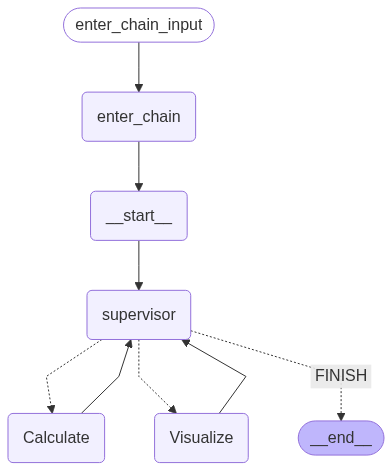

In [31]:
from IPython.display import Image, display

display(Image(colabfold_chain.get_graph().draw_mermaid_png()))

In [32]:
thermompnn_calc_agent = create_agent(
    llm,
    [run_thermompnn_prediction],
    "You are a calculation agent that runs ThermoMPNN predictions",
)

thermompnn_viz_agent = create_agent(
    llm,
    [visualize_thermompnn_3d, visualize_thermompnn_heatmap],
    "You are a visualization agent that creates structure visualizations",
)

# Create team supervisors
thermompnn_supervisor = create_team_supervisor(
    llm,
    "You are supervising the ThermoMPNN team with calculation and visualization agents",
    ["Calculate", "Visualize"],
)

thermompnn_calc_node = functools.partial(
    agent_node, agent=thermompnn_calc_agent, name="ThermoMPNN-Calc"
)
thermompnn_viz_node = functools.partial(
    agent_node, agent=thermompnn_viz_agent, name="ThermoMPNN-Viz"
)

# Create the ThermoMPNN subgraph
thermompnn_graph = StateGraph(ProteinState)
thermompnn_graph.add_node("Calculate", thermompnn_calc_node)
thermompnn_graph.add_node("Visualize", thermompnn_viz_node)
thermompnn_graph.add_node("supervisor", thermompnn_supervisor)

# Add edges
thermompnn_graph.add_edge("Calculate", "supervisor")
thermompnn_graph.add_edge("Visualize", "supervisor")
thermompnn_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Calculate": "Calculate", "Visualize": "Visualize", "FINISH": END},
)

# Set entry point
thermompnn_graph.set_entry_point("supervisor")

chain = thermompnn_graph.compile()
thermompnn_chain = enter_chain | chain

## DNA and Gene Analysis

### DNA Sequence Generation

The system includes advanced DNA analysis using the Evo foundation model:

**Model Capabilities:**
- Taxonomically-aware sequence generation
- Long-range genomic context understanding
- Biologically plausible sequence outputs

In [33]:
#!python -m evo2.test.test_evo2_generation --model_name evo2_7b

In [34]:
EVO2_MODE = False

In [35]:
if EVO2_MODE:
    !python -m pip install evo2==0.3.0
    from evo2 import Evo2

    model_name = "evo2_7b"
    evo_model = Evo2(model_name)
else:
    #!python -m pip install evo-model
    !python -m pip -q install flash-attn==2.7.3
    !python -m pip -q install stripedhyena
    from stripedhyena.tokenizer import CharLevelTokenizer

    model_config = AutoConfig.from_pretrained(
        "togethercomputer/evo-1-131k-base",
        trust_remote_code=True,
        revision="1.1_fix",
    )
    model_config.use_cache = True

    evo_model = AutoModelForCausalLM.from_pretrained(
        "togethercomputer/evo-1-131k-base",
        config=model_config,
        trust_remote_code=True,
        revision="1.1_fix",
    )
    evo_tokenizer = CharLevelTokenizer(512)
    evo_model.to(device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [36]:
sequence_folder = "./sequence"
proteins_fasta = "./proteins.fasta"
protein_structure_pdb = "./protein_structure.pdb"
output_probabilities = "output_probabilities.json"
max_tokens = 1024


@tool
def run_dna_generation(input_text: str = None, number_of_sequences=5):
    "Generate DNA sequence using evo model"
    if not input_text:
        input_text = (
            "|"  # -> start prompt
            + "d__Bacteria;"
            + "p__Pseudomonadota;"
            + "c__Gammaproteobacteria;"
            + "o__Enterobacterales;"
            + "f__Enterobacteriaceae;"
            + "g__Escherichia;"
            + "s__Escherichia"
            + "|"  # -> end prompt
        )
    if EVO2_MODE:
        # Generate species tag
        dna_sequence = evo_model.generate(
            [input_text],
            n_tokens=100,
            temperature=0.7,
        )

    else:
        encoded_chars = evo_tokenizer.tokenize(input_text)

        inputs_tensor = torch.tensor([encoded_chars], dtype=torch.long).to(device)
        outputs = evo_model.generate(
            inputs_tensor, max_new_tokens=50
        )  # Generate 50 new tokens after the input
        generated_ids_list = outputs[0].tolist()
        dna_sequence = evo_tokenizer.decode(generated_ids_list)

    print("dna_sequence")
    print(dna_sequence)

    with open(output_probabilities, "w", encoding="utf-8") as f:
        json.dump(dna_sequence, f, ensure_ascii=False, indent=4)

    for i in range(number_of_sequences):
        gen_dna_seq = dna_sequence.sequences[i]

        gen_dna_seq_record = SeqRecord(
            Seq(gen_dna_seq), id="evo-dna", description="DNA sequence generated by Evo."
        )

        sequence_fasta = f"{sequence_folder}/sequence{i}.fasta"

        with open(sequence_fasta, "w") as output_handle:
            SeqIO.write(gen_dna_seq_record, output_handle, "fasta")

    return dna_sequence

### Protein Coding Gene Prediction

**Prodigal Features:**
- Metagenomic gene finding
- Translation initiation site prediction
- Codon usage analysis
- GFF format output

In [37]:
import os
from pathlib import Path
from tempfile import TemporaryDirectory


@tool
def predict_protein_coding_genes(sequence_folder: str = "sequence") -> str:
    """
    Predict protein-coding genes from all FASTA files in the specified folder using Prodigal.
    Returns concatenated predicted protein sequences from all files.
    """
    from subprocess import run, CalledProcessError

    output_proteins = []

    fasta_files = Path(sequence_folder).glob("*.fasta")
    with TemporaryDirectory() as tmpdir:
        for fasta in fasta_files:
            base_name = fasta.stem
            proteins_fasta = Path(tmpdir) / f"{base_name}_proteins.faa"
            gff_file = Path(tmpdir) / f"{base_name}_genes.gff"
            try:
                run(
                    [
                        "prodigal",
                        "-i",
                        str(fasta),
                        "-a",
                        str(proteins_fasta),
                        "-o",
                        str(gff_file),
                        "-p",
                        "meta",
                        "-f",
                        "gff",
                    ],
                    check=True,
                )

                with open(proteins_fasta, "r") as f:
                    output_proteins.append(f.read())

            except CalledProcessError as e:
                output_proteins.append(f"Error processing {fasta.name}: {e}")

    return (
        "\n".join(output_proteins)
        if output_proteins
        else "No FASTA files found or Prodigal failed."
    )


@tool
def plot_dna_token_probabilities(probabilities: List[float] = []) -> None:
    """Plot token probabilities and gene coordinates"""
    if not probabilities:
        with open(output_probabilities) as data_file:
            output = json.load(data_file)
            gen_dna_logprobs = output["choices"][0]["logprobs"]["token_logprobs"]
            probabilities = np.exp(gen_dna_logprobs)

    # Calculate exponential moving average
    def exponential_moving_average(x, alpha: float = 0.1):
        """little helper to compute exponential moving average over input array x"""
        ema = [x[0]]
        for i in range(1, len(x)):
            ema_value = alpha * x[i] + (1 - alpha) * ema[i - 1]
            ema.append(ema_value)
        return np.array(ema)

    ema_gen_dna_probs = exponential_moving_average(probabilities)
    fig, ax = plt.subplots(1, 1, figsize=(24, 3))
    ax.bar(np.arange(ema_gen_dna_probs.shape[0]), ema_gen_dna_probs, color="C0")
    ax.plot(ema_gen_dna_probs, color="C1", label="EMA")
    if proteins_fasta:

        def extract_start_end_coords(sequences):
            """a little helper to extract the start and
            end coordinates of the predicted protein-coding
            genes"""
            coordinates = []
            for record in sequences:
                start, end = map(
                    int, [info.strip() for info in record.description.split("#")[1:3]]
                )
                coordinates.append((start, end))
            return coordinates

        gene_seqs = load_fasta_from_path(proteins_fasta)
        gene_coords = extract_start_end_coords(gene_seqs)

        for ci, coords in enumerate(gene_coords):
            ax.fill_between(
                coords,
                -0.1,
                0,
                color=f"C{4+ci}",
                alpha=0.75,
                edgecolor="k",
                linewidth=2,
                label=f"coding region {ci+1}",
                zorder=-99,
            )
    ax.set_xlabel("Token position")
    ax.set_ylabel("Probability")
    ax.set_xlim(0, max_tokens)
    ax.set_ylim(-0.15, 1)
    ax.legend(frameon=True, loc="upper center", ncols=2, fontsize="large")
    return fig.show()

## Integration with Main System

The subgraphs integrate with the larger protein analysis system (`master_graph`) through agents and nodes:

In [80]:
utility_agent = create_agent(
    llm,
    [save_pdb, load_pdb, get_sequence],  # download_pdb
    "You are a utility agent that handles PDB file operations and fetches protein sequence from NCBI given a protein name",
)
esmfold_agent = create_agent(
    llm, [run_esmfold_prediction], "Run esmfold protein structure prediction"
)
dna_agent = create_agent(
    llm,
    [plot_dna_token_probabilities, predict_protein_coding_genes, run_dna_generation],
    "Generate DNA sequences, predict protein coding genes and visualize DNA token probabilities",
)
protein_generation_agent = create_agent(
    llm,
    [generate_protein, validate_sequences],
    "Generate and validate protein sequences.",
)
properties_agent = create_agent(
    llm,
    [calculate_properties, generate_mutation_heatmap],
    "You analyze protein properties and mutation impacts.",
)
visualization_agent = create_agent(
    llm,
    [visualize_structure, visualize_network, visualize_coldspots],
    "You visualize protein structures using standard 3dmol or cold spot scanner and networks.",
)

protein_generation_node = functools.partial(
    agent_node, agent=protein_generation_agent, name="Protein Generation"
)
properties_node = functools.partial(
    agent_node, agent=properties_agent, name="Propery Calculation"
)
visualization_node = functools.partial(
    agent_node, agent=visualization_agent, name="Visualization"
)
esmfold_node = functools.partial(agent_node, agent=esmfold_agent, name="Run ESMFold")
dna_node = functools.partial(agent_node, agent=dna_agent, name="DNA Calculations")
utility_node = functools.partial(agent_node, agent=utility_agent, name="Run Utility")

# Create team supervisors
supervisor = create_team_supervisor(
    llm,
    """You are supervising the Protein team with multiple calculation methods and visualization agents
    Unless specified, do not run the same tool twice in a row!!

    To create or generate a new protein - run Generate Protein
    To calculate protein properties and mutation impacts - run Calculate Properties
    To visualize a protein or a network - run Visualize
    To load/save/download a pdb or find sequence by name - use Run Utility
    To calculate protein structure using ColabFold or Alphafold - use Run ColabFold
    To calculate protein structure using ESMFold - use Run ESMFold
    To calculate stability of protein using ThermoMPNN - use Run ThermoMPNN
    To generate DNA sequences, predict protein coding genes and visualize DNA token probabilities - run DNA Calculations
    Unless specified, do not run the same tool twice in a row!!
    When finished, respond with FINISH.""",
    [
        "Generate Protein",
        "Calculate Properties",
        "Visualize",
        "Run ColabFold",
        "Run ThermoMPNN",
        "DNA Calculations",
    ],  # "Run Utility",
)

# Create main graph
master_graph = StateGraph(ProteinState)
master_graph.add_node("Manager", supervisor)
master_graph.add_node("Generate Protein", protein_generation_agent)
master_graph.add_node("Calculate Properties", properties_agent)
master_graph.add_node("Visualize", visualization_agent)
master_graph.add_node("Run ColabFold", get_last_message | colabfold_chain | join_graph)
master_graph.add_node(
    "Run ThermoMPNN", get_last_message | thermompnn_chain | join_graph
)
master_graph.add_node("Run Utility", utility_node)
master_graph.add_node("DNA Calculations", dna_node)
master_graph.add_edge("Generate Protein", "Manager")
master_graph.add_edge("Visualize", "Manager")
master_graph.add_edge("Run Utility", "Manager")
master_graph.add_edge("Run ColabFold", "Manager")
master_graph.add_edge("Run ThermoMPNN", "Manager")
master_graph.add_edge("DNA Calculations", "Manager")

master_graph.add_conditional_edges(
    "Calculate Properties",
    lambda x: (
        "Visualize" if "visualize" in x["messages"][-1].content.lower() else "Manager"
    ),
    {
        "Visualize": "Visualize",
        "Manager": "Manager",
    },
)

master_graph.add_conditional_edges(
    "Manager",
    lambda x: x["next"],
    {
        "Generate Protein": "Generate Protein",
        "Run ColabFold": "Run ColabFold",
        "Calculate Properties": "Calculate Properties",
        "Visualize": "Visualize",
        "Run ThermoMPNN": "Run ThermoMPNN",
        "DNA Calculations": "DNA Calculations",
        "Run Utility": "Run Utility",
        "FINISH": END,
    },
)
master_graph.set_entry_point("Manager")

# add Cold_Spot_Scanner

In [81]:
# Compile the graph
workflow = master_graph.compile()

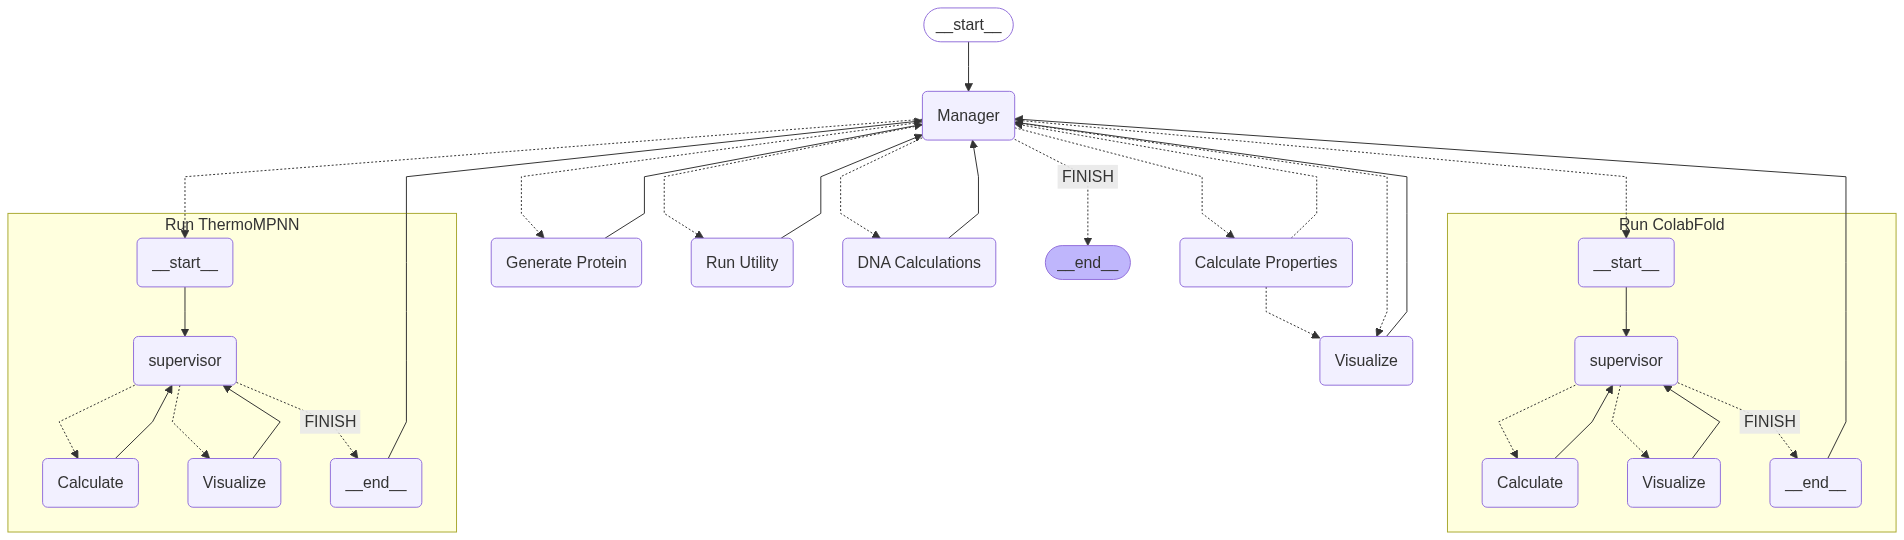

In [82]:
from IPython.display import Image, display

display(Image(workflow.get_graph(xray=True).draw_mermaid_png()))

## Workflow Examples

### Example 1: Comprehensive Stability Analysis

**Query**: "analyze pdb:1dc9 ThermoMPNN stability and show both its heatmap and 3D visualization"

**Execution Flow:**
1. Master Supervisor routes to ThermoMPNN team
2. ThermoMPNN Supervisor delegates to Calculation Agent
3. Calculation Agent downloads PDB, runs stability analysis
4. Visualization Agent creates both heatmap and 3D visualizations
5. Results returned to user

{'next': 'Run ThermoMPNN'}
----


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Identified the following disulfide engaged residues: []


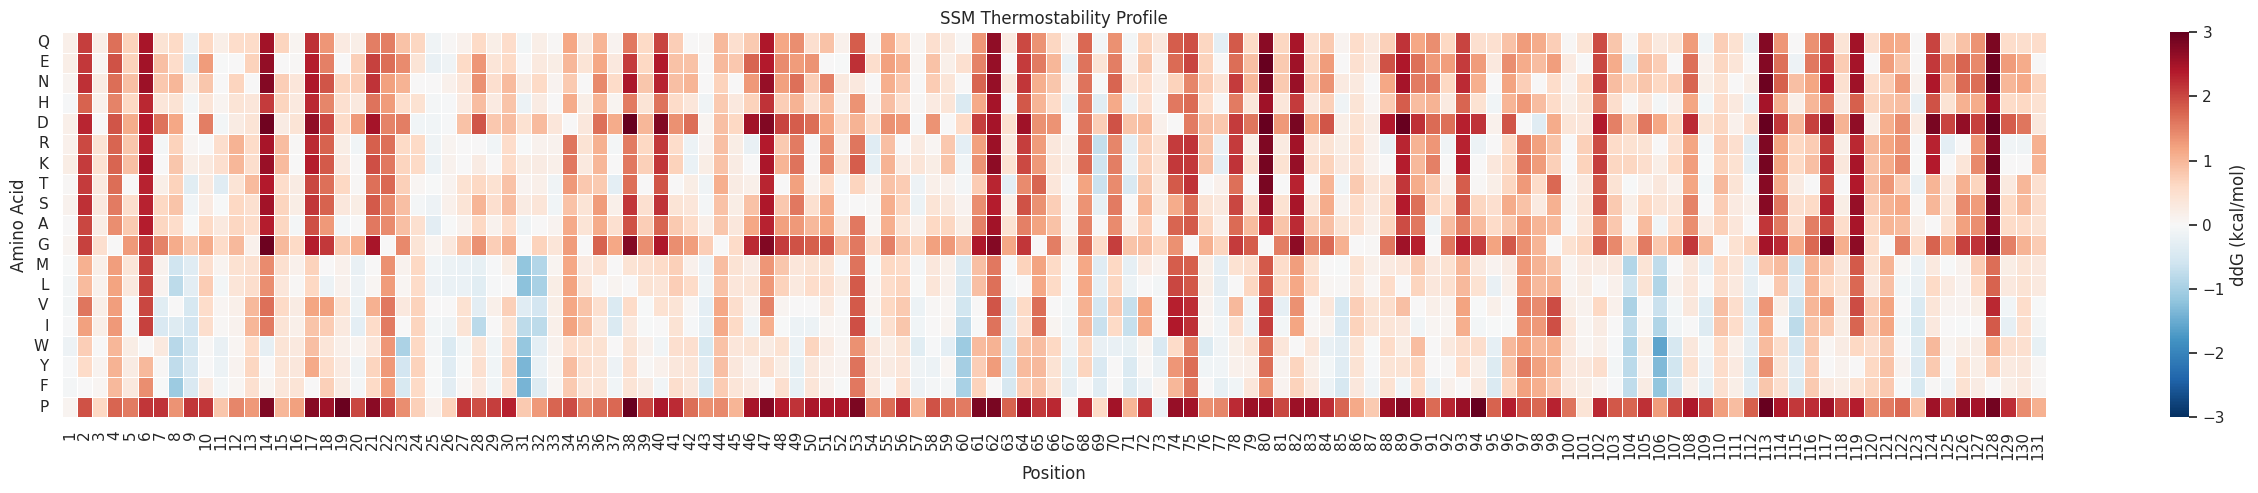

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Identified the following disulfide engaged residues: []


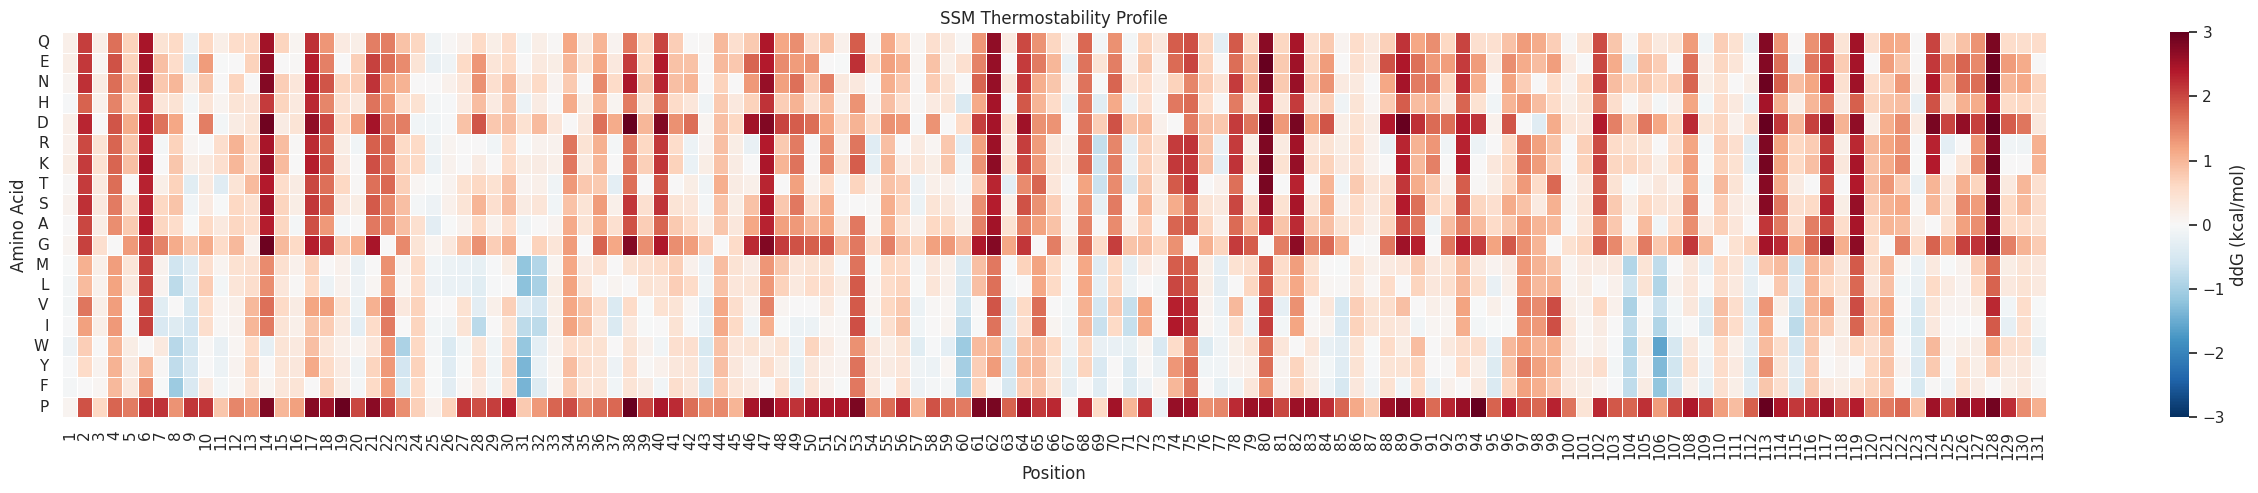

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Identified the following disulfide engaged residues: []


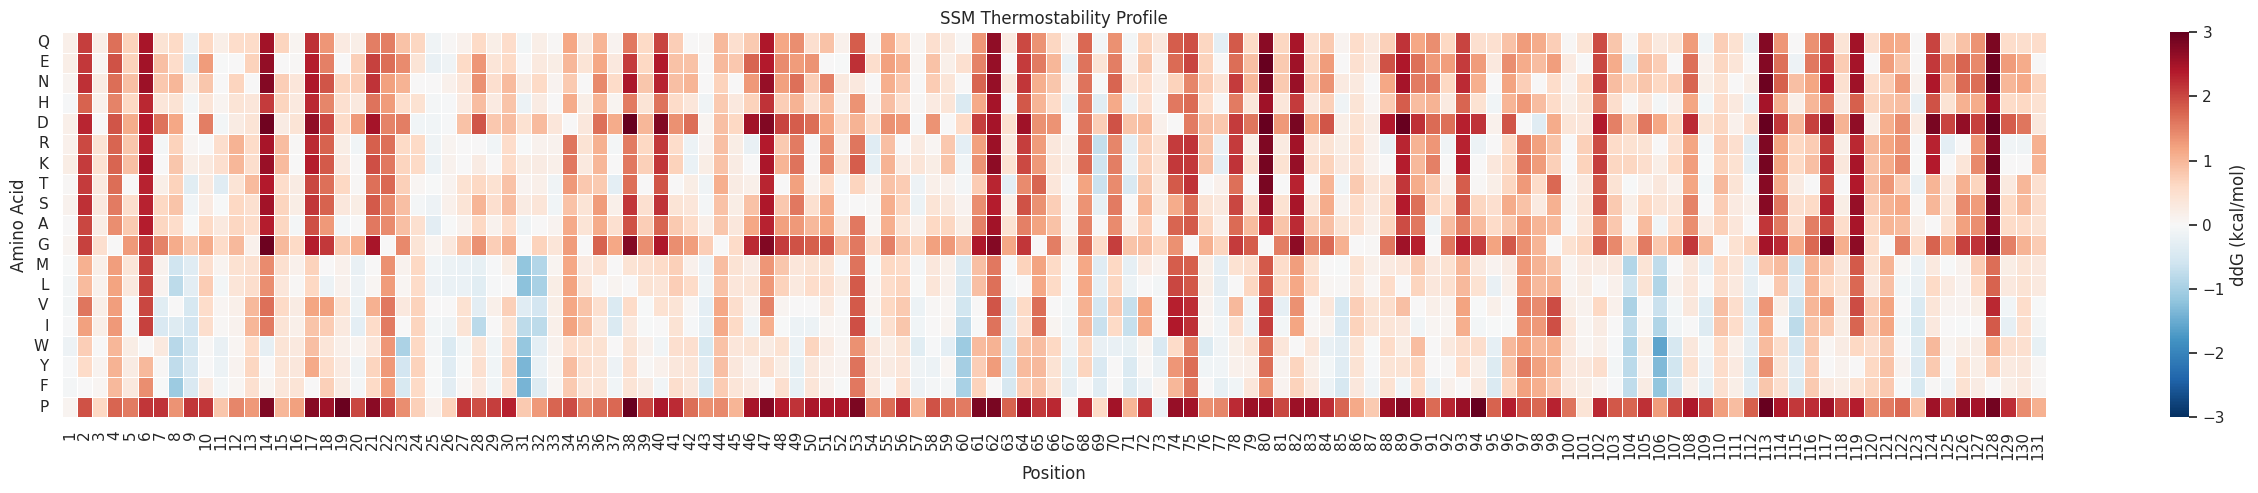

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

{'messages': [HumanMessage(content="It seems there was an issue generating the heatmap and 3D visualization for the protein structure PDB ID 1DC9, and I was unable to retrieve the visualizations.\n\nWould you like to try again, or perhaps explore a different PDB entry? If you have specific parameters or aspects you'd like to focus on, please let me know how you'd like to proceed!", additional_kwargs={}, response_metadata={}, name='ThermoMPNN-Viz')]}
----
{'next': 'Run ThermoMPNN'}
----
Failed: [Errno 2] No such file or directory: '/content/1DC9_thermompnn_predictions.json'


In [77]:
query = """analyze pdb:1dc9 ThermoMPNN stability and show both its heatmap and 3D visualization"""
input_message = [HumanMessage(content=query)]

try:
    for s in workflow.stream({"messages": input_message, "recursion_limit": 5}):
        print(list(s.values())[0])
        print("----")

except Exception as e:
    print(f"Failed: {e}")

### Example 2: Cold Spot Identification

**Query**: "visualize pdb:1PXV with chains A and C with cold spot scanner"

**Process:**
1. Download protein complex structure
2. Initialize Cold-Spot-Scanner database
3. Identify critical interaction residues
4. Generate 3D visualization highlighting cold spots
5. Distinguish CH vs SC interaction types

In [83]:
query = """visualize pdb:1PXV with chains A and C with cold spot scanner"""
input_message = [HumanMessage(content=query)]

try:
    for s in workflow.stream({"messages": input_message, "recursion_limit": 5}):
        print(list(s.values())[0])
        print("----")

except Exception as e:
    print(f"Failed: {e}")

{'next': 'Visualize'}
----
visualize_coldspots
1PXV
1PXV
visualize_coldspots2
1PXV
/content/Cold-Spot-Scanner
pdb_file: 1PXV
input_str: 1PXV_A:C
/content/Cold-Spot-Scanner
/content/Cold-Spot-Scanner/setupPpiDb.py:7: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
WORKING DIR: /content/Cold-Spot-Scanner
Starting molprobity 1PXV
reduce: version 3.11 02/28/2008, Copyright 1997-2008, J. Michael Word
Processing file: "a1PXV"
Database of HETATM connections: "/usr/local/reduce_wwPDB_het_dict.txt"
Processing only 'A' conformations.
VDW dot density = 16/A^2
Orientation penalty scale = 1 (100%)
Eliminate contacts within 3 bonds.
Ignore atoms with |occupancy| <= 0.01 during adjustments.
Waters ignored if B-Factor >= 40 or |occupancy| < 0.66
Aromatic rings in amino acids accept hydrogen bonds.
Building or keeping OH & SH Hydrogens.
Rotating NH3 Hydrogens.
Processing Met methyls.
ERROR CTab(/usr/local/redu

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

{'messages': [HumanMessage(content='visualize pdb:1PXV with chains A and C with cold spot scanner', additional_kwargs={}, response_metadata={})], 'next': 'Visualize'}
----
{'next': 'Visualize'}
----
visualize_coldspots
1PXV
1PXV
visualize_coldspots2
1PXV
/content/Cold-Spot-Scanner
pdb_file: 1PXV
input_str: 1PXV_A:C
/content/Cold-Spot-Scanner
Traceback (most recent call last):
  File "/content/Cold-Spot-Scanner/init_database.py", line 133, in <module>
    createDataBase()
  File "/content/Cold-Spot-Scanner/init_database.py", line 15, in createDataBase
    cur.execute('''CREATE TABLE `perAtomASA` (
sqlite3.OperationalError: table `perAtomASA` already exists
/content/Cold-Spot-Scanner/setupPpiDb.py:7: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
WORKING DIR: /content/Cold-Spot-Scanner
Starting molprobity 1PXV
reduce: version 3.11 02/28/2008, Copyright 1997-2008, J. Michael Word
Processing file

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

{'messages': [HumanMessage(content='visualize pdb:1PXV with chains A and C with cold spot scanner', additional_kwargs={}, response_metadata={}), HumanMessage(content='visualize pdb:1PXV with chains A and C with cold spot scanner', additional_kwargs={}, response_metadata={})], 'next': 'Visualize'}
----
{'next': 'Visualize'}
----
visualize_coldspots
1PXV
1PXV
visualize_coldspots2
1PXV
/content/Cold-Spot-Scanner
pdb_file: 1PXV
input_str: 1PXV_A:C
/content/Cold-Spot-Scanner
Traceback (most recent call last):
  File "/content/Cold-Spot-Scanner/init_database.py", line 133, in <module>
    createDataBase()
  File "/content/Cold-Spot-Scanner/init_database.py", line 15, in createDataBase
    cur.execute('''CREATE TABLE `perAtomASA` (
sqlite3.OperationalError: table `perAtomASA` already exists
/content/Cold-Spot-Scanner/setupPpiDb.py:7: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
WORKING DIR: /conte

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

{'messages': [HumanMessage(content='visualize pdb:1PXV with chains A and C with cold spot scanner', additional_kwargs={}, response_metadata={}), HumanMessage(content='visualize pdb:1PXV with chains A and C with cold spot scanner', additional_kwargs={}, response_metadata={}), HumanMessage(content='visualize pdb:1PXV with chains A and C with cold spot scanner', additional_kwargs={}, response_metadata={}), HumanMessage(content='visualize pdb:1PXV with chains A and C with cold spot scanner', additional_kwargs={}, response_metadata={})], 'next': 'Visualize'}
----
{'next': 'Visualize'}
----
visualize_coldspots
1PXV
1PXV
visualize_coldspots2
1PXV
/content/Cold-Spot-Scanner
pdb_file: 1PXV
input_str: 1PXV_A:C
/content/Cold-Spot-Scanner
Traceback (most recent call last):
  File "/content/Cold-Spot-Scanner/init_database.py", line 133, in <module>
    createDataBase()
  File "/content/Cold-Spot-Scanner/init_database.py", line 15, in createDataBase
    cur.execute('''CREATE TABLE `perAtomASA` (
sql

### Example 3: DNA-to-Protein Pipeline

**Query**: "Generate a DNA sequence, calculate the protein coding genes and visualize DNA token probabilities"

**Workflow:**
1. Generate taxonomically-informed DNA sequence using Evo
2. Predict protein-coding genes with Prodigal
3. Calculate and visualize token probabilities
4. Map predicted genes to probability landscape

In [43]:
if device == "cuda":
    query = """Generate a DNA sequence, calculate the protein coding genes and visualize DNA token probabilities"""
    input_message = [HumanMessage(content=query)]

    try:
        for s in workflow.stream({"messages": input_message}):
            print(list(s.values())[0])
            print("----")

    except Exception as e:
        print(f"Failed: {e}")

{'next': 'DNA Calculations'}
----
Initializing inference params...
Failed: Internal Triton PTX codegen error
`ptxas` stderr:
ptxas /tmp/tmpt0jv4aba.ptx, line 192; error   : Feature '.bf16' requires .target sm_80 or higher
ptxas /tmp/tmpt0jv4aba.ptx, line 192; error   : Feature 'cvt with .f32.bf16' requires .target sm_80 or higher
ptxas /tmp/tmpt0jv4aba.ptx, line 196; error   : Feature '.bf16' requires .target sm_80 or higher
ptxas /tmp/tmpt0jv4aba.ptx, line 196; error   : Feature 'cvt with .f32.bf16' requires .target sm_80 or higher
ptxas /tmp/tmpt0jv4aba.ptx, line 200; error   : Feature '.bf16' requires .target sm_80 or higher
ptxas /tmp/tmpt0jv4aba.ptx, line 200; error   : Feature 'cvt with .f32.bf16' requires .target sm_80 or higher
ptxas /tmp/tmpt0jv4aba.ptx, line 204; error   : Feature '.bf16' requires .target sm_80 or higher
ptxas /tmp/tmpt0jv4aba.ptx, line 204; error   : Feature 'cvt with .f32.bf16' requires .target sm_80 or higher
ptxas /tmp/tmpt0jv4aba.ptx, line 231; error   :

### Example 4: Protein Generation and Mutation Analysis

**Query**: "Generate 3 proteins and calculate their mutation impacts"

**Workflow:**
- Generates 3 protein sequences using ProtGPT2
- Calculates mutation impact heatmaps for each protein
- Shows the predicted effects of amino acid substitutions

In [44]:
if device == "cuda":
    query = """Generate 3 proteins and calculate their mutation impacts"""
    input_message = [HumanMessage(content=query)]

    try:
        for s in workflow.stream({"messages": input_message}):
            print(list(s.values())[0])
            print("----")

    except Exception as e:
        print(f"Failed: {e}")

{'next': 'Generate Protein'}
----


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generated proteins: [{'generated_text': '<|endoftext|>\nMRVYKTLWIITFIFLLTACQAEANTKIVKNTPTIKNNTILSEPTLIPTHTPLPIITNTPS\nPTDTPVPPTSTPTPAPLPTATPVPTATPSPVATSLPYVDGIFYPTNQPDNTFKGYYFIGD\nGEKNTDSNGNYDSSYGLIFLSDKVIRITWYTDNEPNFLTCRLEGGDILVDKDENRILSNS\nGDTLNICVNDSYSGQPHSYLPCKQ\n'}]


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generated proteins: [{'generated_text': '<|endoftext|>\nMNKVTILVVDDSPSVLKILDDILTAEGYTTHTASSAEEALKFLEESKADLIISDINMPGI\nNGFELIKRIRKNEKFSHIPFILLTSKSEEENRLKGLKIGADDYITKPFNKEELLARVKSR\nLKLKDIQDRLSQKVKELNTLLATINEVNRAILKVKDKKQLLQEACKIAIEQGKFRVAWLG\nFIDEKTGKVKPETWYGLSENYLDNIKINWSETEKGKGPTGTAIRTNKPIINNDIANDPRF\nKPWRDEALKRGFKSSIALPLIYGDKVIGAFSIYSSEPNAFTEEEIKLMQEVANDLAFGIS\nLLEIERKRRESEKKEQELKKFHNKVMEFQEEEKLRISRELHDELGQSLTALKMNLSWLKN\nNLPKDQKEIEEKIDETIGILDSTIENVRNISLALRPSILDDLGLVAAIEWHVQEFTKKTG\nIDCEFKNDISDYPVSQEIATTLYRVFQESLTNVAKHANATKVEVKLTKKDQNLKLEIKDN\nGKGFDPDKIKNSKSLGLLGIRERIMLLNGDFKIESSPGEGTILKAEIPLN\n'}]


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generated proteins: [{'generated_text': '<|endoftext|>\nMFLIKYNLLKIISVIIVFIITIFNFKQTYAKNYEINLNNSNLNDNIYNISKNYIINNNIE\nLIINNENTQINIYFNDNTSQIKSNKSIKINNKNYNLNKDISLINSNLYIPISFINKTLNK\nNLEFDIKNNIIFIKNNNIIKSFIINYEKIKDYINPQNILLPNTIINFNLNNFNIDLDNQT\nISLTNKIENFIQSKYKMFIVNDNDNINRDQIFNYIIKNNLITKNLILDSSNIINKNKITN\nFSIKKIPLNYSNIEIFSDGKIINILKLKNEPIIINNGKINININNINNLINENIEIKINN\nKEYYQILNNNSNIINLDNLIMNKKLDINIYYNNKIIDLNNINPSIELNKGKLNINLTNNK\nIDFNGIETSLDLDKGKLEIKTNKINLNNKKDISLEVLNGRFNMKNIDISSNISIKDGILN\nININKNNLINLSNLEANIEIDNSKIDLNIGNENLNIDKNSKIILNSSDILINNIKIENKI\nSINNGSINLNLNNTNFNNKNIKSKIDINNGSINVNIQNNNLNLNIKDANININNDSLNMN\nVENKEININNGKISINNEDIDIDVNNAKIGLNNSNININVDNKNLKVDKDSIILDSNDIK\nINIDNKKVNFDNSNIQISINKTNVNINNGKIDINIENNEINIDKSNIRINNSNILIDINK\nKYLTLKNADVNLNDSNINIDVNKDLISIDNTKI'}]
Failed: StructuredTool._run() got multiple values for argument 'self'


### Example 5: ColabFold Structure Prediction and Visualization

**Query**: "Run ColabFold prediction for sequence MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG and visualize the results"

**Workflow:**
- Takes the provided protein sequence
- Runs ColabFold structure prediction
- Generates 3D structure visualization with confidence coloring
- Creates quality assessment plots (pLDDT and PAE)

In [45]:
# currently cause memory crash

'''
query = """Run ColabFold prediction for sequence MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG and visualize the results"""
input_message = [HumanMessage(content=query)]

try:
  for s in workflow.stream({"messages": input_message}):
      print(list(s.values())[0])
      print("----")

except Exception as e:
  print(f"Failed: {e}")
'''

'\nquery = """Run ColabFold prediction for sequence MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG and visualize the results"""\ninput_message = [HumanMessage(content=query)]\n\ntry:\n  for s in workflow.stream({"messages": input_message}):\n      print(list(s.values())[0])\n      print("----")\n\nexcept Exception as e:\n  print(f"Failed: {e}")\n'

## Technical Implementation Details

### Error Handling and Validation

The system includes robust error handling:
- PDB file validation and automatic download
- Sequence format checking
- Chain existence verification
- Missing data imputation

### Performance Optimizations

- GPU acceleration for neural network models
- Efficient memory management for large structures
- Caching of intermediate results
- Parallel processing where applicable

### Output Formats

Multiple output formats are supported:
- **JSON**: Structured data for programmatic access
- **CSV**: Tabular results for analysis
- **PDB**: Standard protein structure format
- **PNG/PDF**: High-quality visualizations

---

## Applications and Use Cases

### Drug Discovery
- Target identification through cold spot analysis
- Lead optimization via stability profiling
- Binding site characterization

### Protein Engineering
- Stability enhancement design
- Function optimization
- Novel protein creation

### Structural Biology
- Structure validation and assessment
- Conformational analysis
- Complex characterization

### Genomics
- Gene annotation and validation
- Functional sequence analysis
- Evolutionary studies

---

## Limitations and Considerations

### Computational Requirements
- GPU memory limitations for large proteins
- Processing time scales with sequence length
- Storage requirements for intermediate files

### Model Accuracy
- Confidence score interpretation
- Limitations for membrane proteins
- Accuracy degradation for very long sequences

### Experimental Validation
- In silico predictions require experimental confirmation
- Context-dependent effects not fully captured
- Dynamic behavior not modeled

---

## Conclusion

This multi-agent protein analysis system demonstrates the power of combining specialized AI tools with orchestrated workflows. The LangGraph framework enables sophisticated coordination between different analysis methods, providing researchers with a comprehensive platform for protein research.

The system's modular design allows for easy extension and customization, making it adaptable to various research needs and computational environments. As the underlying models continue to improve, this framework provides a robust foundation for integrating next-generation protein analysis tools.